# KL Divergence Playground: Model Drift Detection

**Goal:** Understand and compare different methods for detecting when your LLM API provider silently swaps models.

## Setup

In [1]:
# Install dependencies (run once)
!pip install numpy scipy scikit-learn matplotlib seaborn -q

zsh:1: command not found: pip


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import cdist
from scipy.special import rel_entr
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from typing import Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Nice plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✓ Setup complete")

Matplotlib is building the font cache; this may take a moment.


✓ Setup complete


---
## Part 1: The Math Behind KL Divergence

### Definition

$$D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)} = \mathbb{E}_{x \sim P}\left[\log \frac{P(x)}{Q(x)}\right]$$

**Intuition:** How many extra bits do you need to encode samples from P using a code optimized for Q?

### Properties
- $D_{KL} \geq 0$ (always non-negative)
- $D_{KL} = 0$ iff $P = Q$
- **NOT symmetric:** $D_{KL}(P\|Q) \neq D_{KL}(Q\|P)$
- **NOT a metric:** doesn't satisfy triangle inequality

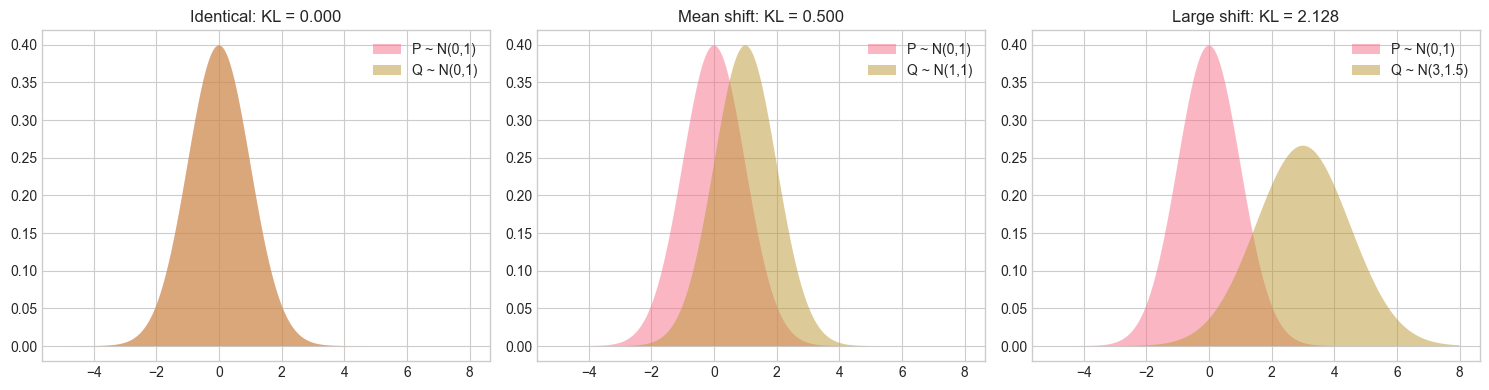

In [4]:
# Visualize KL divergence for simple 1D Gaussians

def plot_kl_intuition():
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    x = np.linspace(-5, 8, 1000)
    
    # Case 1: Same distribution
    p1 = stats.norm.pdf(x, 0, 1)
    q1 = stats.norm.pdf(x, 0, 1)
    kl1 = 0.0
    
    axes[0].fill_between(x, p1, alpha=0.5, label='P ~ N(0,1)')
    axes[0].fill_between(x, q1, alpha=0.5, label='Q ~ N(0,1)')
    axes[0].set_title(f'Identical: KL = {kl1:.3f}')
    axes[0].legend()
    
    # Case 2: Mean shift
    p2 = stats.norm.pdf(x, 0, 1)
    q2 = stats.norm.pdf(x, 1, 1)
    # KL for Gaussians: (μ1-μ2)²/2σ² + σ1²/2σ2² - 1/2 + log(σ2/σ1)
    kl2 = 0.5  # (1-0)²/2 = 0.5
    
    axes[1].fill_between(x, p2, alpha=0.5, label='P ~ N(0,1)')
    axes[1].fill_between(x, q2, alpha=0.5, label='Q ~ N(1,1)')
    axes[1].set_title(f'Mean shift: KL = {kl2:.3f}')
    axes[1].legend()
    
    # Case 3: Large shift
    p3 = stats.norm.pdf(x, 0, 1)
    q3 = stats.norm.pdf(x, 3, 1.5)
    kl3 = 0.5 * ((0-3)**2 / 1.5**2 + 1/1.5**2 - 1 + 2*np.log(1.5/1))
    
    axes[2].fill_between(x, p3, alpha=0.5, label='P ~ N(0,1)')
    axes[2].fill_between(x, q3, alpha=0.5, label='Q ~ N(3,1.5)')
    axes[2].set_title(f'Large shift: KL = {kl3:.3f}')
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()

plot_kl_intuition()

---
## Part 2: KL Estimation Methods

We have samples, not distributions. How do we estimate KL?

### Method 1: Histogram (Binning)

In [5]:
def kl_binned(p_samples, q_samples, n_bins=50, eps=1e-10):
    """
    Estimate KL via histograms.
    
    Pros: Simple, fast, interpretable
    Cons: Bin edges matter, curse of dimensionality
    """
    # For high-dim, project to 1D first
    if p_samples.ndim > 1:
        pca = PCA(n_components=1)
        combined = np.vstack([p_samples, q_samples])
        pca.fit(combined)
        p_samples = pca.transform(p_samples).flatten()
        q_samples = pca.transform(q_samples).flatten()
    
    # Shared bin edges
    all_data = np.concatenate([p_samples, q_samples])
    bin_edges = np.linspace(all_data.min() - eps, all_data.max() + eps, n_bins + 1)
    
    # Histograms
    p_hist, _ = np.histogram(p_samples, bins=bin_edges)
    q_hist, _ = np.histogram(q_samples, bins=bin_edges)
    
    # Normalize + smoothing
    p_prob = (p_hist + eps) / (p_hist + eps).sum()
    q_prob = (q_hist + eps) / (q_hist + eps).sum()
    
    # KL
    kl = np.sum(rel_entr(p_prob, q_prob))
    return kl

# Test it
np.random.seed(42)
p = np.random.randn(500)
q = np.random.randn(500) + 0.5  # Shifted

print(f"KL (binned, 20 bins): {kl_binned(p, q, n_bins=20):.4f}")
print(f"KL (binned, 50 bins): {kl_binned(p, q, n_bins=50):.4f}")
print(f"KL (binned, 100 bins): {kl_binned(p, q, n_bins=100):.4f}")
print(f"\nTrue KL for N(0,1) vs N(0.5,1): {0.5**2 / 2:.4f}")

KL (binned, 20 bins): 0.2818
KL (binned, 50 bins): 0.3916
KL (binned, 100 bins): 1.2078

True KL for N(0,1) vs N(0.5,1): 0.1250


### Method 2: Kernel Density Estimation (KDE)

In [6]:
def kl_kde(p_samples, q_samples, bandwidth='auto'):
    """
    Estimate KL via Kernel Density Estimation.
    
    Pros: Smooth, works for continuous data
    Cons: Bandwidth selection is tricky, expensive in high-dim
    """
    if p_samples.ndim == 1:
        p_samples = p_samples.reshape(-1, 1)
        q_samples = q_samples.reshape(-1, 1)
    
    n, d = p_samples.shape
    
    # Bandwidth selection
    if bandwidth == 'auto':
        # Scott's rule
        bandwidth = n ** (-1.0 / (d + 4)) * np.std(p_samples)
    
    # Fit KDEs
    kde_p = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(p_samples)
    kde_q = KernelDensity(bandwidth=bandwidth, kernel='gaussian').fit(q_samples)
    
    # Monte Carlo estimate: KL = E_p[log p - log q]
    log_p = kde_p.score_samples(p_samples)
    log_q = kde_q.score_samples(p_samples)
    
    kl = np.mean(log_p - log_q)
    return max(0, kl)

# Test it
print(f"KL (KDE, auto bandwidth): {kl_kde(p, q):.4f}")
print(f"KL (KDE, bw=0.2): {kl_kde(p, q, bandwidth=0.2):.4f}")
print(f"KL (KDE, bw=0.5): {kl_kde(p, q, bandwidth=0.5):.4f}")
print(f"KL (KDE, bw=1.0): {kl_kde(p, q, bandwidth=1.0):.4f}")

KL (KDE, auto bandwidth): 0.1533
KL (KDE, bw=0.2): 0.1854
KL (KDE, bw=0.5): 0.1172
KL (KDE, bw=1.0): 0.0696


### Method 3: k-Nearest Neighbors

In [7]:
def kl_knn(p_samples, q_samples, k=5):
    """
    Estimate KL via k-Nearest Neighbor distances.
    
    Based on: The ratio of distances to k-th neighbor in P vs Q
    tells us about the density ratio.
    
    Pros: Works in high dimensions, no density estimation
    Cons: O(n²) complexity, sensitive to k
    """
    if p_samples.ndim == 1:
        p_samples = p_samples.reshape(-1, 1)
        q_samples = q_samples.reshape(-1, 1)
    
    n, d = p_samples.shape
    m = len(q_samples)
    
    # k-th neighbor distances within P
    nn_p = NearestNeighbors(n_neighbors=k+1).fit(p_samples)
    rho, _ = nn_p.kneighbors(p_samples)
    rho = rho[:, -1]  # k-th neighbor (exclude self)
    
    # k-th neighbor distances from P to Q
    nn_q = NearestNeighbors(n_neighbors=k).fit(q_samples)
    nu, _ = nn_q.kneighbors(p_samples)
    nu = nu[:, -1]
    
    # Avoid log(0)
    rho = np.maximum(rho, 1e-10)
    nu = np.maximum(nu, 1e-10)
    
    # KL estimate
    kl = d * np.mean(np.log(nu / rho)) + np.log(m / (n - 1))
    return max(0, kl)

# Test it
print(f"KL (k-NN, k=3): {kl_knn(p, q, k=3):.4f}")
print(f"KL (k-NN, k=5): {kl_knn(p, q, k=5):.4f}")
print(f"KL (k-NN, k=10): {kl_knn(p, q, k=10):.4f}")
print(f"KL (k-NN, k=20): {kl_knn(p, q, k=20):.4f}")

KL (k-NN, k=3): 0.1450
KL (k-NN, k=5): 0.1303
KL (k-NN, k=10): 0.1486
KL (k-NN, k=20): 0.1308


### Method 4: Classifier Two-Sample Test

**Key insight:** If a classifier can distinguish P from Q, they're different!

In [8]:
def kl_classifier(p_samples, q_samples, cv_folds=5):
    """
    Estimate divergence via classifier accuracy.
    
    Train classifier to distinguish P vs Q.
    - 50% accuracy = identical
    - 100% accuracy = completely different
    
    Pros: Works great in high dimensions, robust
    Cons: Indirect measure of KL
    """
    if p_samples.ndim == 1:
        p_samples = p_samples.reshape(-1, 1)
        q_samples = q_samples.reshape(-1, 1)
    
    # Create dataset
    X = np.vstack([p_samples, q_samples])
    y = np.array([0] * len(p_samples) + [1] * len(q_samples))
    
    # Cross-validated accuracy
    clf = LogisticRegression(max_iter=1000)
    scores = cross_val_score(clf, X, y, cv=cv_folds)
    accuracy = np.mean(scores)
    
    # Convert accuracy to approximate divergence
    # Higher accuracy = more different distributions
    acc_centered = np.clip(2 * (accuracy - 0.5), 0.001, 0.999)
    kl_approx = 2 * np.arctanh(acc_centered) ** 2
    
    return kl_approx, accuracy

# Test it
kl_clf, acc = kl_classifier(p, q)
print(f"Classifier accuracy: {acc:.1%}")
print(f"Approximate KL: {kl_clf:.4f}")

Classifier accuracy: 59.8%
Approximate KL: 0.0789


### Method 5: Maximum Mean Discrepancy (MMD)

Not KL, but often **more reliable** for high-dimensional data.

In [9]:
def mmd_squared(p_samples, q_samples, gamma=None):
    """
    Maximum Mean Discrepancy squared.
    
    Measures distance in kernel (RKHS) space.
    MMD² = E[k(x,x')] + E[k(y,y')] - 2*E[k(x,y)]
    
    Pros: No density estimation, works in high-dim, well-understood
    Cons: Kernel selection matters
    """
    if p_samples.ndim == 1:
        p_samples = p_samples.reshape(-1, 1)
        q_samples = q_samples.reshape(-1, 1)
    
    # Median heuristic for gamma
    if gamma is None:
        combined = np.vstack([p_samples, q_samples])
        dists = cdist(combined, combined, 'euclidean')
        median_dist = np.median(dists[dists > 0])
        gamma = 1.0 / (2 * median_dist ** 2 + 1e-10)
    
    def rbf(X, Y):
        return np.exp(-gamma * cdist(X, Y, 'sqeuclidean'))
    
    K_pp = rbf(p_samples, p_samples)
    K_qq = rbf(q_samples, q_samples)
    K_pq = rbf(p_samples, q_samples)
    
    n, m = len(p_samples), len(q_samples)
    
    # Unbiased estimator
    np.fill_diagonal(K_pp, 0)
    np.fill_diagonal(K_qq, 0)
    
    mmd2 = (K_pp.sum() / (n * (n-1)) + 
            K_qq.sum() / (m * (m-1)) - 
            2 * K_pq.sum() / (n * m))
    
    return max(0, mmd2)

# Test it
print(f"MMD² (auto gamma): {mmd_squared(p, q):.6f}")
print(f"MMD² (gamma=0.5): {mmd_squared(p, q, gamma=0.5):.6f}")
print(f"MMD² (gamma=1.0): {mmd_squared(p, q, gamma=1.0):.6f}")
print(f"MMD² (gamma=2.0): {mmd_squared(p, q, gamma=2.0):.6f}")

MMD² (auto gamma): 0.055027
MMD² (gamma=0.5): 0.055068
MMD² (gamma=1.0): 0.051012
MMD² (gamma=2.0): 0.041864


---
## Part 3: Compare All Methods

Let's see how each method behaves across different drift magnitudes.

In [10]:
def compare_methods(p_samples, q_samples, true_kl=None):
    """Compare all KL estimation methods."""
    results = {
        'Binned (50)': kl_binned(p_samples, q_samples, n_bins=50),
        'KDE (auto)': kl_kde(p_samples, q_samples),
        'k-NN (k=5)': kl_knn(p_samples, q_samples, k=5),
        'Classifier': kl_classifier(p_samples, q_samples)[0],
        'MMD² (×100)': mmd_squared(p_samples, q_samples) * 100,  # Scale for visibility
    }
    
    # Also get classifier accuracy
    _, clf_acc = kl_classifier(p_samples, q_samples)
    results['Clf Accuracy'] = clf_acc
    
    return results

# Test across drift magnitudes
np.random.seed(42)
n_samples = 500
p_base = np.random.randn(n_samples)

shifts = [0.0, 0.25, 0.5, 1.0, 2.0]
all_results = []

print("Drift Magnitude Study (1D Gaussians)\n")
print(f"{'Shift':>6} | {'Binned':>8} | {'KDE':>8} | {'k-NN':>8} | {'Clf KL':>8} | {'MMD²×100':>8} | {'Clf Acc':>8} | {'True KL':>8}")
print("-" * 85)

for shift in shifts:
    q = np.random.randn(n_samples) + shift
    true_kl = shift**2 / 2  # Analytical KL for Gaussians
    
    results = compare_methods(p_base, q, true_kl)
    all_results.append({'shift': shift, 'true_kl': true_kl, **results})
    
    print(f"{shift:>6.2f} | {results['Binned (50)']:>8.4f} | {results['KDE (auto)']:>8.4f} | "
          f"{results['k-NN (k=5)']:>8.4f} | {results['Classifier']:>8.4f} | "
          f"{results['MMD² (×100)']:>8.4f} | {results['Clf Accuracy']:>7.1%} | {true_kl:>8.4f}")

Drift Magnitude Study (1D Gaussians)

 Shift |   Binned |      KDE |     k-NN |   Clf KL | MMD²×100 |  Clf Acc |  True KL
-------------------------------------------------------------------------------------
  0.00 |   0.2753 |   0.0237 |   0.0000 |   0.0000 |   0.0000 |   49.9% |   0.0000
  0.25 |   0.4916 |   0.0800 |   0.0549 |   0.0445 |   2.5936 |   57.4% |   0.0312
  0.50 |   0.6088 |   0.1543 |   0.1077 |   0.1038 |   6.1200 |   61.2% |   0.1250
  1.00 |   1.1227 |   0.5047 |   0.4214 |   0.3314 |  18.7989 |   69.3% |   0.5000
  2.00 |   6.1143 |   2.0727 |   1.7681 |   1.5742 |  57.9420 |   85.5% |   2.0000


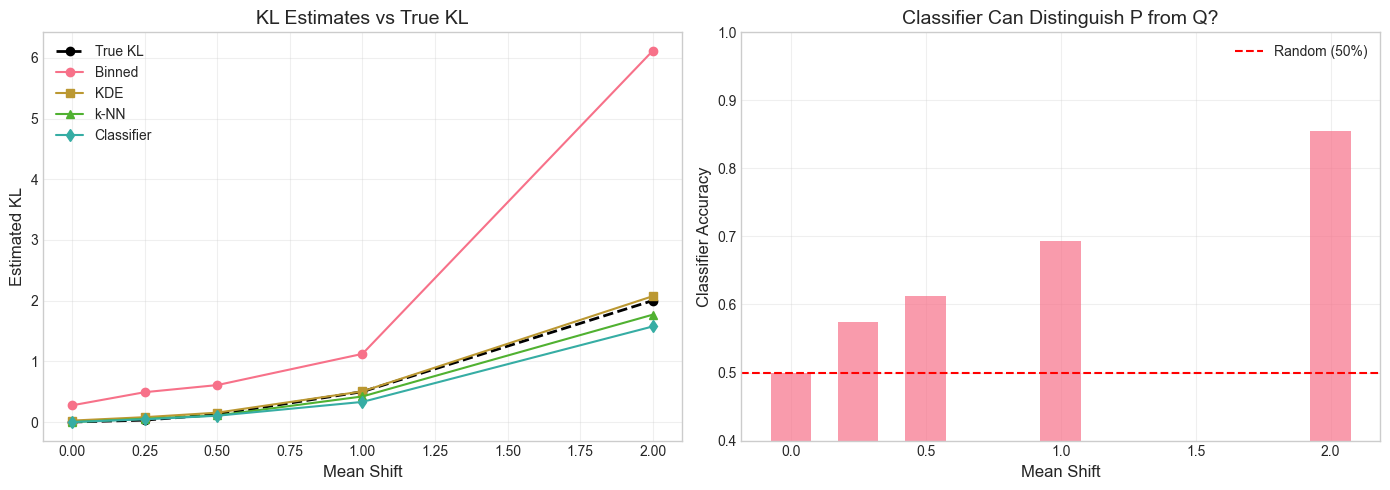

In [11]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: KL estimates vs true KL
shifts = [r['shift'] for r in all_results]
true_kls = [r['true_kl'] for r in all_results]

axes[0].plot(shifts, true_kls, 'k--', linewidth=2, label='True KL', marker='o')
axes[0].plot(shifts, [r['Binned (50)'] for r in all_results], '-o', label='Binned')
axes[0].plot(shifts, [r['KDE (auto)'] for r in all_results], '-s', label='KDE')
axes[0].plot(shifts, [r['k-NN (k=5)'] for r in all_results], '-^', label='k-NN')
axes[0].plot(shifts, [r['Classifier'] for r in all_results], '-d', label='Classifier')

axes[0].set_xlabel('Mean Shift', fontsize=12)
axes[0].set_ylabel('Estimated KL', fontsize=12)
axes[0].set_title('KL Estimates vs True KL', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Classifier accuracy
axes[1].bar(shifts, [r['Clf Accuracy'] for r in all_results], width=0.15, alpha=0.7)
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random (50%)')
axes[1].set_xlabel('Mean Shift', fontsize=12)
axes[1].set_ylabel('Classifier Accuracy', fontsize=12)
axes[1].set_title('Classifier Can Distinguish P from Q?', fontsize=14)
axes[1].set_ylim(0.4, 1.0)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 4: High-Dimensional Experiments

Real embeddings are 384-1536 dimensions. How do methods behave?

In [12]:
def high_dim_experiment(dim, n_samples=300, shift_magnitude=0.5):
    """
    Test KL estimation in high dimensions.
    
    Shift is applied in a random direction.
    """
    np.random.seed(42)
    
    # Reference distribution
    p = np.random.randn(n_samples, dim)
    
    # Shifted distribution (random direction)
    shift_dir = np.random.randn(dim)
    shift_dir = shift_dir / np.linalg.norm(shift_dir)  # Unit vector
    q = np.random.randn(n_samples, dim) + shift_magnitude * shift_dir
    
    results = {}
    
    # Binned (with PCA)
    results['Binned'] = kl_binned(p, q, n_bins=50)
    
    # KDE (usually fails in high dim)
    try:
        results['KDE'] = kl_kde(p, q)
    except:
        results['KDE'] = np.nan
    
    # k-NN
    results['k-NN'] = kl_knn(p, q, k=3)
    
    # Classifier (most reliable)
    kl_clf, acc = kl_classifier(p, q)
    results['Classifier KL'] = kl_clf
    results['Classifier Acc'] = acc
    
    # MMD
    results['MMD²'] = mmd_squared(p, q)
    
    return results

# Test across dimensions
dims = [2, 8, 32, 64, 128, 256, 512]
dim_results = []

print("High-Dimensional Experiment (shift=0.5 in random direction)\n")
print(f"{'Dim':>6} | {'Binned':>8} | {'KDE':>8} | {'k-NN':>8} | {'Clf KL':>8} | {'MMD²':>10} | {'Clf Acc':>8}")
print("-" * 75)

for dim in dims:
    r = high_dim_experiment(dim, shift_magnitude=0.5)
    dim_results.append({'dim': dim, **r})
    
    print(f"{dim:>6} | {r['Binned']:>8.4f} | {r['KDE']:>8.4f} | "
          f"{r['k-NN']:>8.4f} | {r['Classifier KL']:>8.4f} | "
          f"{r['MMD²']:>10.6f} | {r['Classifier Acc']:>7.1%}")

High-Dimensional Experiment (shift=0.5 in random direction)

   Dim |   Binned |      KDE |     k-NN |   Clf KL |       MMD² |  Clf Acc
---------------------------------------------------------------------------
     2 |   0.6290 |   0.2693 |   0.1597 |   0.0794 |   0.032522 |   59.8%
     8 |   0.6745 |   3.0954 |   0.1409 |   0.1097 |   0.014895 |   61.5%
    32 |   0.9181 |  20.5451 |   0.0000 |   0.0151 |   0.001631 |   54.3%
    64 |   0.3801 |  38.7015 |   0.0000 |   0.0324 |   0.001546 |   56.3%
   128 |   0.2668 |  59.8186 |   0.3585 |   0.0909 |   0.001809 |   60.5%
   256 |   0.5100 | 116.1271 |   0.4831 |   0.0000 |   0.000097 |   47.8%
   512 |   0.3281 | 234.7090 |   0.6871 |   0.0118 |   0.000140 |   53.8%


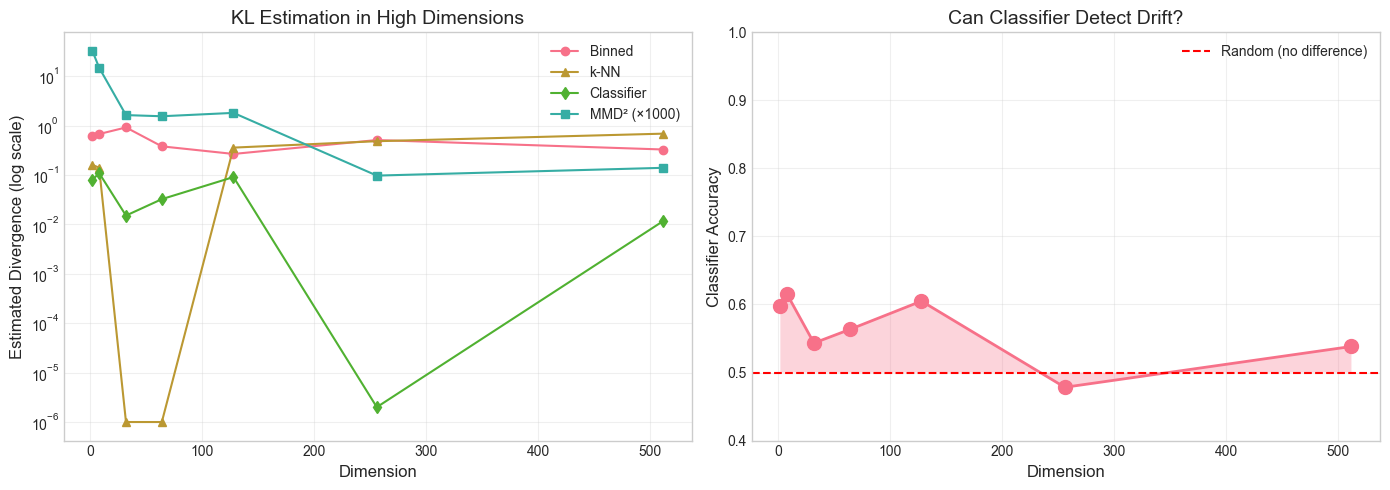

In [13]:
# Visualize high-dim behavior
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

dims = [r['dim'] for r in dim_results]

# Plot 1: Different estimators
axes[0].semilogy(dims, [r['Binned'] for r in dim_results], '-o', label='Binned')
axes[0].semilogy(dims, [max(r['k-NN'], 1e-6) for r in dim_results], '-^', label='k-NN')
axes[0].semilogy(dims, [r['Classifier KL'] for r in dim_results], '-d', label='Classifier')
axes[0].semilogy(dims, [r['MMD²'] * 1000 for r in dim_results], '-s', label='MMD² (×1000)')

axes[0].set_xlabel('Dimension', fontsize=12)
axes[0].set_ylabel('Estimated Divergence (log scale)', fontsize=12)
axes[0].set_title('KL Estimation in High Dimensions', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Classifier accuracy (most interpretable)
axes[1].plot(dims, [r['Classifier Acc'] for r in dim_results], '-o', linewidth=2, markersize=10)
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random (no difference)')
axes[1].fill_between(dims, 0.5, [r['Classifier Acc'] for r in dim_results], alpha=0.3)

axes[1].set_xlabel('Dimension', fontsize=12)
axes[1].set_ylabel('Classifier Accuracy', fontsize=12)
axes[1].set_title('Can Classifier Detect Drift?', fontsize=14)
axes[1].set_ylim(0.4, 1.0)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 5: Statistical Significance

KL > 0 from sampling noise. Is the drift **real**?

In [14]:
def permutation_test(p_samples, q_samples, kl_func, n_permutations=500):
    """
    Test if KL is significantly different from zero.
    
    H0: P = Q (no drift)
    H1: P ≠ Q (drift)
    
    Procedure:
    1. Compute observed KL
    2. Shuffle labels, compute KL (null distribution)
    3. p-value = fraction of null KLs >= observed
    """
    # Observed
    if p_samples.ndim == 1:
        p_samples = p_samples.reshape(-1, 1)
        q_samples = q_samples.reshape(-1, 1)
    
    observed = kl_func(p_samples, q_samples)
    
    # Null distribution
    combined = np.vstack([p_samples, q_samples])
    n_p = len(p_samples)
    
    null_kls = []
    for _ in range(n_permutations):
        perm = np.random.permutation(len(combined))
        perm_p = combined[perm[:n_p]]
        perm_q = combined[perm[n_p:]]
        null_kls.append(kl_func(perm_p, perm_q))
    
    null_kls = np.array(null_kls)
    p_value = np.mean(null_kls >= observed)
    
    return {
        'observed': observed,
        'null_mean': np.mean(null_kls),
        'null_std': np.std(null_kls),
        'p_value': p_value,
        'significant': p_value < 0.05,
        'null_distribution': null_kls
    }

# Test
np.random.seed(42)
p = np.random.randn(300)

print("Permutation Test Results\n")
print("="*60)

# Case 1: No drift
q_same = np.random.randn(300)
result = permutation_test(p, q_same, lambda x, y: kl_binned(x.flatten(), y.flatten()))
print(f"\nNo Drift (same distribution):")
print(f"  Observed KL: {result['observed']:.4f}")
print(f"  Null mean:   {result['null_mean']:.4f} ± {result['null_std']:.4f}")
print(f"  p-value:     {result['p_value']:.4f}")
print(f"  Significant: {'YES ⚠️' if result['significant'] else 'NO ✓'}")

# Case 2: Small drift
q_small = np.random.randn(300) + 0.3
result = permutation_test(p, q_small, lambda x, y: kl_binned(x.flatten(), y.flatten()))
print(f"\nSmall Drift (shift=0.3):")
print(f"  Observed KL: {result['observed']:.4f}")
print(f"  Null mean:   {result['null_mean']:.4f} ± {result['null_std']:.4f}")
print(f"  p-value:     {result['p_value']:.4f}")
print(f"  Significant: {'YES ⚠️' if result['significant'] else 'NO ✓'}")

# Case 3: Large drift
q_large = np.random.randn(300) + 1.0
result = permutation_test(p, q_large, lambda x, y: kl_binned(x.flatten(), y.flatten()))
print(f"\nLarge Drift (shift=1.0):")
print(f"  Observed KL: {result['observed']:.4f}")
print(f"  Null mean:   {result['null_mean']:.4f} ± {result['null_std']:.4f}")
print(f"  p-value:     {result['p_value']:.4f}")
print(f"  Significant: {'YES ⚠️' if result['significant'] else 'NO ✓'}")

Permutation Test Results


No Drift (same distribution):
  Observed KL: 0.5246
  Null mean:   0.5827 ± 0.2286
  p-value:     0.5200
  Significant: NO ✓

Small Drift (shift=0.3):
  Observed KL: 0.3340
  Null mean:   0.5897 ± 0.2664
  p-value:     0.8440
  Significant: NO ✓

Large Drift (shift=1.0):
  Observed KL: 3.2441
  Null mean:   0.5393 ± 0.2178
  p-value:     0.0000
  Significant: YES ⚠️


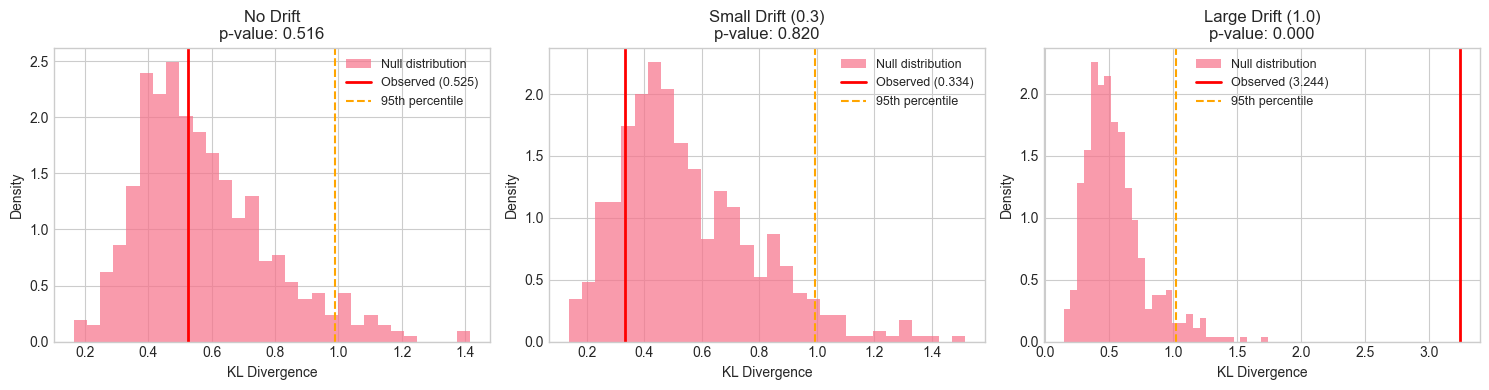

In [15]:
# Visualize null distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (q, title) in zip(axes, [
    (q_same, 'No Drift'),
    (q_small, 'Small Drift (0.3)'),
    (q_large, 'Large Drift (1.0)')
]):
    result = permutation_test(p, q, lambda x, y: kl_binned(x.flatten(), y.flatten()), n_permutations=500)
    
    ax.hist(result['null_distribution'], bins=30, alpha=0.7, density=True, label='Null distribution')
    ax.axvline(result['observed'], color='red', linewidth=2, label=f"Observed ({result['observed']:.3f})")
    ax.axvline(np.percentile(result['null_distribution'], 95), color='orange', 
               linestyle='--', label='95th percentile')
    
    ax.set_xlabel('KL Divergence')
    ax.set_ylabel('Density')
    ax.set_title(f"{title}\np-value: {result['p_value']:.3f}")
    ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

---
## Part 6: Interactive Playground 🎮

Tweak parameters and see what happens!

In [16]:
# ===== PLAYGROUND: MODIFY THESE PARAMETERS =====

# Distribution settings
N_SAMPLES = 500          # Number of samples
DIMENSION = 32           # Embedding dimension
MEAN_SHIFT = 0.5         # How much to shift the mean
VAR_SCALE = 1.0          # Variance scaling (1.0 = same, 1.5 = 50% more variance)

# Method parameters
N_BINS = 50              # For binned method
KDE_BANDWIDTH = 'auto'   # 'auto' or float (e.g., 0.3)
KNN_K = 5                # For k-NN method

# ===============================================

np.random.seed(42)

# Generate data
p_samples = np.random.randn(N_SAMPLES, DIMENSION)

shift_direction = np.random.randn(DIMENSION)
shift_direction = shift_direction / np.linalg.norm(shift_direction)

q_samples = np.random.randn(N_SAMPLES, DIMENSION) * VAR_SCALE + MEAN_SHIFT * shift_direction

print("="*60)
print("PLAYGROUND RESULTS")
print("="*60)
print(f"\nSettings:")
print(f"  Samples: {N_SAMPLES}")
print(f"  Dimension: {DIMENSION}")
print(f"  Mean shift: {MEAN_SHIFT}")
print(f"  Variance scale: {VAR_SCALE}")

print(f"\n" + "-"*60)
print("KL Estimates:")
print("-"*60)

# Run all methods
print(f"  Binned ({N_BINS} bins):  {kl_binned(p_samples, q_samples, n_bins=N_BINS):.4f}")

try:
    kde_result = kl_kde(p_samples, q_samples, bandwidth=KDE_BANDWIDTH)
    print(f"  KDE (bw={KDE_BANDWIDTH}):       {kde_result:.4f}")
except Exception as e:
    print(f"  KDE: Failed ({e})")

print(f"  k-NN (k={KNN_K}):         {kl_knn(p_samples, q_samples, k=KNN_K):.4f}")

kl_clf, acc = kl_classifier(p_samples, q_samples)
print(f"  Classifier:        {kl_clf:.4f} (accuracy: {acc:.1%})")

print(f"  MMD²:              {mmd_squared(p_samples, q_samples):.6f}")

# Significance test
print(f"\n" + "-"*60)
print("Statistical Significance (Classifier-based):")
print("-"*60)

def clf_divergence(p, q):
    return kl_classifier(p, q)[0]

result = permutation_test(p_samples, q_samples, clf_divergence, n_permutations=200)
print(f"  Observed:    {result['observed']:.4f}")
print(f"  Null mean:   {result['null_mean']:.4f} ± {result['null_std']:.4f}")
print(f"  p-value:     {result['p_value']:.4f}")
print(f"  Verdict:     {'🚨 DRIFT DETECTED' if result['significant'] else '✅ No significant drift'}")

PLAYGROUND RESULTS

Settings:
  Samples: 500
  Dimension: 32
  Mean shift: 0.5
  Variance scale: 1.0

------------------------------------------------------------
KL Estimates:
------------------------------------------------------------
  Binned (50 bins):  0.4208
  KDE (bw=auto):       20.2652
  k-NN (k=5):         0.0000
  Classifier:        0.0375 (accuracy: 56.8%)
  MMD²:              0.001929

------------------------------------------------------------
Statistical Significance (Classifier-based):
------------------------------------------------------------
  Observed:    0.0375
  Null mean:   0.0014 ± 0.0029
  p-value:     0.0000
  Verdict:     🚨 DRIFT DETECTED


---
## Part 7: Sensitivity Analysis

How much data do you need? How sensitive are the methods?

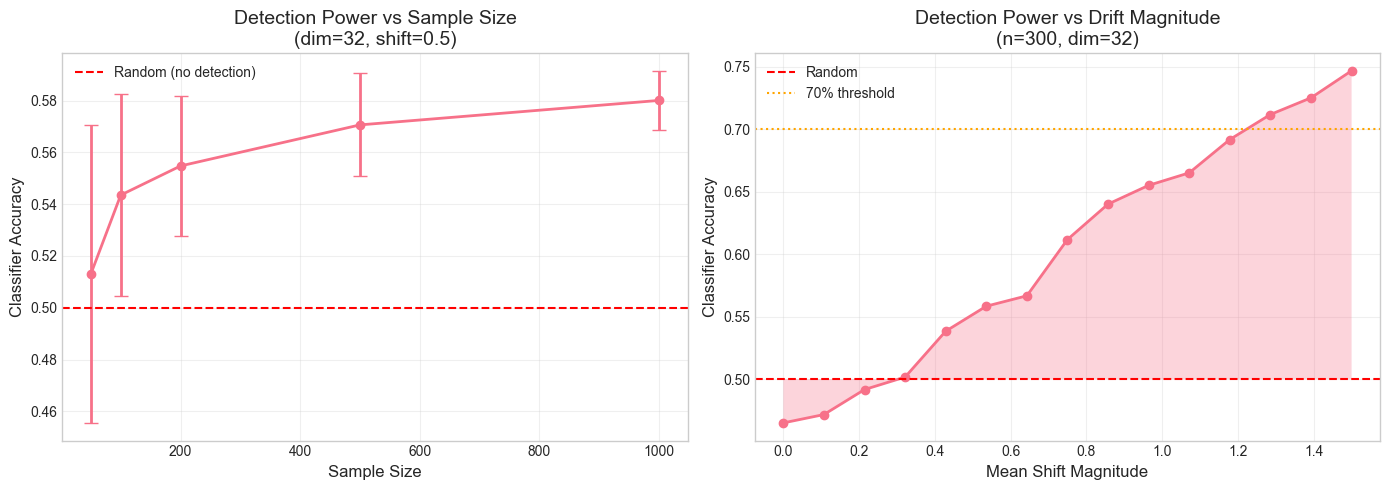

In [17]:
# Sample size sensitivity
sample_sizes = [50, 100, 200, 500, 1000]
dim = 32
shift = 0.5

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

clf_accs = []
clf_accs_std = []

for n in sample_sizes:
    accs = []
    for seed in range(10):  # 10 trials
        np.random.seed(seed)
        p = np.random.randn(n, dim)
        direction = np.random.randn(dim)
        direction = direction / np.linalg.norm(direction)
        q = np.random.randn(n, dim) + shift * direction
        _, acc = kl_classifier(p, q)
        accs.append(acc)
    
    clf_accs.append(np.mean(accs))
    clf_accs_std.append(np.std(accs))

# Plot
axes[0].errorbar(sample_sizes, clf_accs, yerr=clf_accs_std, fmt='-o', capsize=5, linewidth=2)
axes[0].axhline(y=0.5, color='r', linestyle='--', label='Random (no detection)')
axes[0].set_xlabel('Sample Size', fontsize=12)
axes[0].set_ylabel('Classifier Accuracy', fontsize=12)
axes[0].set_title(f'Detection Power vs Sample Size\n(dim={dim}, shift={shift})', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Shift sensitivity
shifts = np.linspace(0, 1.5, 15)
n = 300

shift_accs = []
for s in shifts:
    np.random.seed(42)
    p = np.random.randn(n, dim)
    direction = np.random.randn(dim)
    direction = direction / np.linalg.norm(direction)
    q = np.random.randn(n, dim) + s * direction
    _, acc = kl_classifier(p, q)
    shift_accs.append(acc)

axes[1].plot(shifts, shift_accs, '-o', linewidth=2)
axes[1].axhline(y=0.5, color='r', linestyle='--', label='Random')
axes[1].axhline(y=0.7, color='orange', linestyle=':', label='70% threshold')
axes[1].fill_between(shifts, 0.5, shift_accs, alpha=0.3)
axes[1].set_xlabel('Mean Shift Magnitude', fontsize=12)
axes[1].set_ylabel('Classifier Accuracy', fontsize=12)
axes[1].set_title(f'Detection Power vs Drift Magnitude\n(n={n}, dim={dim})', fontsize=14)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 8: Your Production Checklist

Based on experiments, here's what to use:

In [ ]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║              PRODUCTION DRIFT DETECTION CHECKLIST                ║
╠══════════════════════════════════════════════════════════════════╣
║                                                                  ║
║  1. PRIMARY METRIC: Classifier Accuracy                          ║
║     - Most robust in high dimensions                             ║
║     - Directly interpretable                                     ║
║     - Thresholds:                                                ║
║       • < 60%: No drift                                          ║
║       • 60-70%: Minor drift (monitor)                            ║
║       • 70-80%: Moderate drift (investigate)                     ║
║       • 80-90%: Major drift (alert)                              ║
║       • > 90%: Critical (halt & review)                          ║
║                                                                  ║
║  2. SECONDARY METRIC: MMD²                                       ║
║     - Complements classifier                                     ║
║     - Good for subtle distributional changes                     ║
║                                                                  ║
║  3. SAMPLE SIZE: Minimum 100-200 for reliable detection          ║
║     - More samples = detect smaller drifts                       ║
║     - Window of 100 is good balance                              ║
║                                                                  ║
║  4. DIMENSIONALITY: Reduce via PCA if dim > 128                  ║
║     - 32-64 dims is sweet spot                                   ║
║     - Preserves enough signal for detection                      ║
║                                                                  ║
║  5. STATISTICAL SIGNIFICANCE: Always use permutation test        ║
║     - p-value < 0.05 for significance                            ║
║     - Avoids false alarms from sampling noise                    ║
║                                                                  ║
║  6. REAL-TIME: Use CUSUM for sequential detection                ║
║     - Detects drift within ~5-10 samples of occurrence           ║
║     - Good for continuous monitoring                             ║
║                                                                  ║
╚══════════════════════════════════════════════════════════════════╝
""")

---
## Exercises for You

1. **Variance shift:** What if only variance changes (not mean)? Modify the playground.

2. **Mixed drift:** Some dimensions shift, others don't. Can you detect it?

3. **Gradual drift:** Shift increases slowly over time. When does detection trigger?

4. **Real embeddings:** Load actual sentence-transformer embeddings and test.

In [ ]:
# Exercise 1: Variance-only shift
# TODO: Modify this to test variance changes

np.random.seed(42)
p = np.random.randn(500, 32)

# Change variance, not mean
VARIANCE_SCALE = 1.5  # <-- Try different values: 1.2, 1.5, 2.0
q = np.random.randn(500, 32) * VARIANCE_SCALE

_, acc = kl_classifier(p, q)
print(f"Variance scale: {VARIANCE_SCALE}")
print(f"Classifier accuracy: {acc:.1%}")
print(f"MMD²: {mmd_squared(p, q):.6f}")

In [ ]:
# Exercise 2: Partial dimension shift
# Only first K dimensions shift

np.random.seed(42)
dim = 32
p = np.random.randn(500, dim)
q = np.random.randn(500, dim)

# Shift only first K dimensions
K_DIMS_TO_SHIFT = 8  # <-- Try: 4, 8, 16, 32
SHIFT_AMOUNT = 1.0

q[:, :K_DIMS_TO_SHIFT] += SHIFT_AMOUNT

_, acc = kl_classifier(p, q)
print(f"Shifted {K_DIMS_TO_SHIFT}/{dim} dimensions by {SHIFT_AMOUNT}")
print(f"Classifier accuracy: {acc:.1%}")